<a href="https://colab.research.google.com/github/Harshith-richards/harshi/blob/master/MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 599kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]


Dataset size: 60000
Image shape: torch.Size([1, 28, 28])


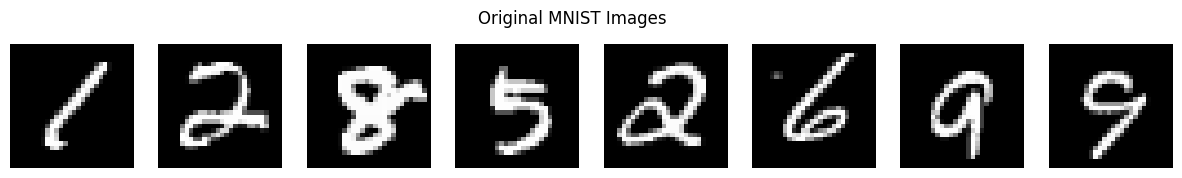

In [2]:
# Transform images to tensors and normalize to [-1, 1] range
# Why normalize? Makes training more stable
transform = transforms.Compose([
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))     # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# DataLoader batches data for efficient training
# batch_size=64: Process 64 images at once (good balance of speed/memory)
# shuffle=True: Randomize order each epoch (prevents overfitting)
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

print(f"Dataset size: {len(train_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")  # [channels, height, width]

# Visualize some training data
def show_images(images, title="Images", num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    for i in range(num_images):
        # Convert from [-1, 1] back to [0, 1] for display
        img = (images[i].squeeze() + 1) / 2
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Get a batch and visualize
sample_batch, _ = next(iter(train_loader))
show_images(sample_batch, "Original MNIST Images")


In [3]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(SimpleAutoencoder, self).__init__()

        # ENCODER: Compress 784 pixels -> latent_dim numbers
        self.encoder = nn.Sequential(
            # Flatten 28x28 image to 784 pixels
            nn.Flatten(),

            # Gradually compress the information
            nn.Linear(784, 256),      # 784 -> 256
            nn.ReLU(),                # Activation: keeps positive values
            nn.Linear(256, 128),      # 256 -> 128
            nn.ReLU(),
            nn.Linear(128, latent_dim) # 128 -> latent_dim (compressed!)
        )

        # DECODER: Expand latent_dim -> 784 pixels
        self.decoder = nn.Sequential(
            # Gradually expand the information
            nn.Linear(latent_dim, 128), # latent_dim -> 128
            nn.ReLU(),
            nn.Linear(128, 256),        # 128 -> 256
            nn.ReLU(),
            nn.Linear(256, 784),        # 256 -> 784
            nn.Tanh(),                  # Output in [-1, 1] (matches our normalization)

            # Reshape back to image format
            nn.Unflatten(1, (1, 28, 28))  # 784 -> [1, 28, 28]
        )

    def forward(self, x):
        # Forward pass through encoder then decoder
        latent = self.encoder(x)      # Compress
        reconstructed = self.decoder(latent)  # Reconstruct
        return reconstructed

    def encode(self, x):
        # Just the encoding part (useful for generating)
        return self.encoder(x)

    def decode(self, latent):
        # Just the decoding part
        return self.decoder(latent)

# Create the model
latent_dim = 32  # How many numbers to compress each image into
model = SimpleAutoencoder(latent_dim=latent_dim).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Latent dimension: {latent_dim}")


Total parameters: 476,720
Latent dimension: 32


In [4]:
# LOSS FUNCTION: How wrong are our reconstructions?
# MSE (Mean Squared Error): Penalizes pixel-wise differences
criterion = nn.MSELoss()

# OPTIMIZER: How to update weights to reduce loss
# Adam is a good default optimizer
# lr=0.001: Learning rate (how big steps to take when updating)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function: MSE (pixel-wise difference)")
print("Optimizer: Adam with learning rate 0.001")


Loss function: MSE (pixel-wise difference)
Optimizer: Adam with learning rate 0.001


Starting training...
Epoch 1/10, Batch 0, Loss: 0.9261
Epoch 1/10, Batch 100, Loss: 0.2068
Epoch 1/10, Batch 200, Loss: 0.1363
Epoch 1/10, Batch 300, Loss: 0.1107
Epoch 1/10, Batch 400, Loss: 0.1076
Epoch 1/10, Batch 500, Loss: 0.0901
Epoch 1/10, Batch 600, Loss: 0.0785
Epoch 1/10, Batch 700, Loss: 0.0844
Epoch 1/10, Batch 800, Loss: 0.0757
Epoch 1/10, Batch 900, Loss: 0.0796
Epoch 1/10 completed. Average Loss: 0.1224
Epoch 2/10, Batch 0, Loss: 0.0612
Epoch 2/10, Batch 100, Loss: 0.0659
Epoch 2/10, Batch 200, Loss: 0.0651
Epoch 2/10, Batch 300, Loss: 0.0596
Epoch 2/10, Batch 400, Loss: 0.0588
Epoch 2/10, Batch 500, Loss: 0.0600
Epoch 2/10, Batch 600, Loss: 0.0512
Epoch 2/10, Batch 700, Loss: 0.0538
Epoch 2/10, Batch 800, Loss: 0.0481
Epoch 2/10, Batch 900, Loss: 0.0505
Epoch 2/10 completed. Average Loss: 0.0585
Epoch 3/10, Batch 0, Loss: 0.0509
Epoch 3/10, Batch 100, Loss: 0.0485
Epoch 3/10, Batch 200, Loss: 0.0448
Epoch 3/10, Batch 300, Loss: 0.0496
Epoch 3/10, Batch 400, Loss: 0.0435

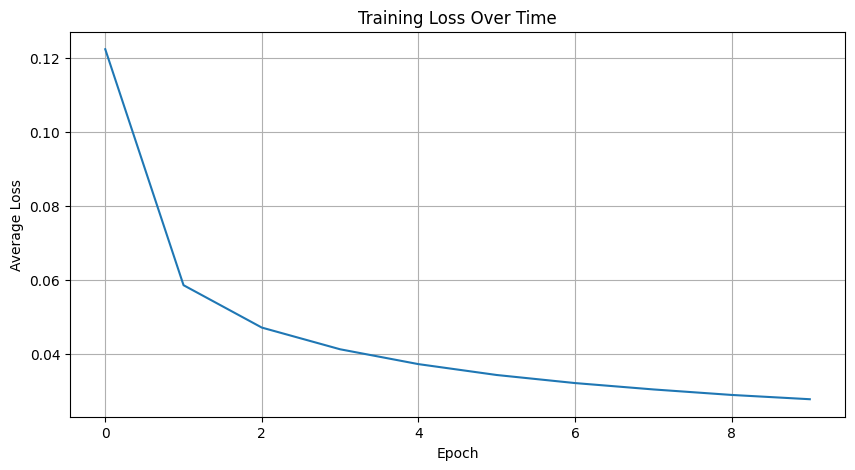

In [5]:
def train_autoencoder(model, train_loader, criterion, optimizer, epochs=10):
    model.train()  # Set to training mode
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            # Move data to device (GPU if available)
            data = data.to(device)

            # FORWARD PASS
            optimizer.zero_grad()          # Clear previous gradients
            reconstructed = model(data)    # Get reconstructions
            loss = criterion(reconstructed, data)  # Compare with originals

            # BACKWARD PASS
            loss.backward()               # Calculate gradients
            optimizer.step()              # Update weights

            epoch_loss += loss.item()
            num_batches += 1

            # Print progress every 100 batches
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        # Average loss for this epoch
        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs} completed. Average Loss: {avg_loss:.4f}')

    return losses

# Train the model
print("Starting training...")
losses = train_autoencoder(model, train_loader, criterion, optimizer, epochs=10)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()


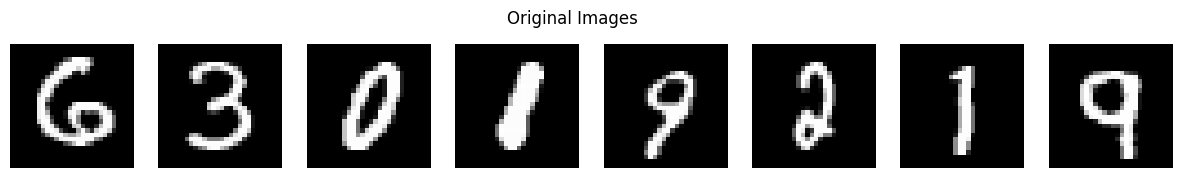

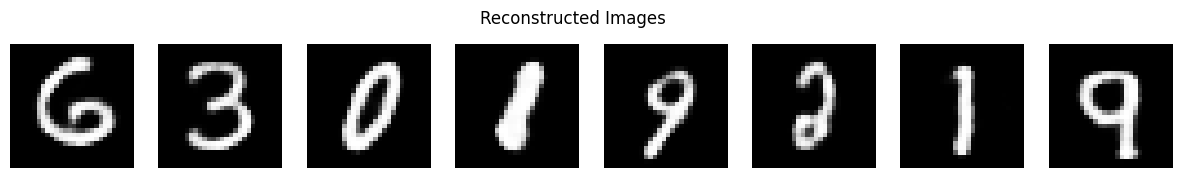

In [6]:
def evaluate_model(model, data_loader, num_samples=8):
    model.eval()  # Set to evaluation mode (no gradient computation)

    with torch.no_grad():  # Don't compute gradients (saves memory/time)
        # Get a batch of test data
        data, _ = next(iter(data_loader))
        data = data.to(device)

        # Get reconstructions
        reconstructed = model(data)

        # Move back to CPU for visualization
        original = data[:num_samples].cpu()
        reconstructed = reconstructed[:num_samples].cpu()

        # Show original vs reconstructed
        show_images(original, "Original Images")
        show_images(reconstructed, "Reconstructed Images")

        return original, reconstructed

# Evaluate on training data
original, reconstructed = evaluate_model(model, train_loader)


Generating new images from random latent codes...


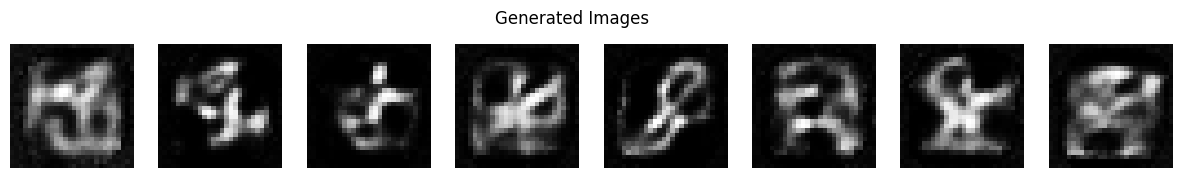

In [7]:
def generate_new_images(model, latent_dim, num_images=8, device=device):
    model.eval()

    with torch.no_grad():
        # Sample random points in latent space
        # These are like "random codes" that we'll decode into images
        random_latent = torch.randn(num_images, latent_dim).to(device)

        # Decode random codes into images
        generated = model.decode(random_latent)

        # Move to CPU for visualization
        generated = generated.cpu()

        show_images(generated, "Generated Images")

        return generated

# Generate completely new images
print("Generating new images from random latent codes...")
generated_images = generate_new_images(model, latent_dim)


In [8]:
print("HYPERPARAMETER GUIDE:")
print("=" * 50)
print(f"Latent Dimension ({latent_dim}): How compressed the representation is")
print("  - Smaller = More compression, less detail, faster training")
print("  - Larger = Less compression, more detail, slower training")
print()
print(f"Batch Size (64): How many images processed together")
print("  - Smaller = More updates, potentially better convergence")
print("  - Larger = Fewer updates, more stable gradients")
print()
print(f"Learning Rate (0.001): How fast the model learns")
print("  - Too small = Very slow learning")
print("  - Too large = Unstable, might not converge")
print()
print(f"Epochs (10): How many times we see the entire dataset")
print("  - More epochs = Better learning (up to a point)")
print("  - Too many = Overfitting")


HYPERPARAMETER GUIDE:
Latent Dimension (32): How compressed the representation is
  - Smaller = More compression, less detail, faster training
  - Larger = Less compression, more detail, slower training

Batch Size (64): How many images processed together
  - Smaller = More updates, potentially better convergence
  - Larger = Fewer updates, more stable gradients

Learning Rate (0.001): How fast the model learns
  - Too small = Very slow learning
  - Too large = Unstable, might not converge

Epochs (10): How many times we see the entire dataset
  - More epochs = Better learning (up to a point)
  - Too many = Overfitting


In [9]:
print("COMMON BEGINNER ISSUES & FIXES:")
print("=" * 50)
print()
print("1. SHAPE ERRORS:")
print("   Error: 'Expected 2D tensor, got 4D'")
print("   Fix: Use nn.Flatten() to convert image to vector")
print("   Fix: Use nn.Unflatten() to convert back to image")
print()
print("2. BAD RECONSTRUCTIONS (blurry/dark):")
print("   Problem: Wrong normalization or activation")
print("   Fix: Use Tanh() output with [-1,1] normalized data")
print("   Fix: Or use Sigmoid() with [0,1] normalized data")
print()
print("3. LOSS NOT DECREASING:")
print("   Problem: Learning rate too high/low")
print("   Fix: Try lr=0.01 (higher) or lr=0.0001 (lower)")
print("   Problem: Model too simple")
print("   Fix: Add more layers or increase latent_dim")
print()
print("4. TRAINING TOO SLOW:")
print("   Fix: Increase batch_size (if you have enough GPU memory)")
print("   Fix: Use GPU if available")
print("   Fix: Reduce model size or image resolution")


COMMON BEGINNER ISSUES & FIXES:

1. SHAPE ERRORS:
   Error: 'Expected 2D tensor, got 4D'
   Fix: Use nn.Flatten() to convert image to vector
   Fix: Use nn.Unflatten() to convert back to image

2. BAD RECONSTRUCTIONS (blurry/dark):
   Problem: Wrong normalization or activation
   Fix: Use Tanh() output with [-1,1] normalized data
   Fix: Or use Sigmoid() with [0,1] normalized data

3. LOSS NOT DECREASING:
   Problem: Learning rate too high/low
   Fix: Try lr=0.01 (higher) or lr=0.0001 (lower)
   Problem: Model too simple
   Fix: Add more layers or increase latent_dim

4. TRAINING TOO SLOW:
   Fix: Increase batch_size (if you have enough GPU memory)
   Fix: Use GPU if available
   Fix: Reduce model size or image resolution


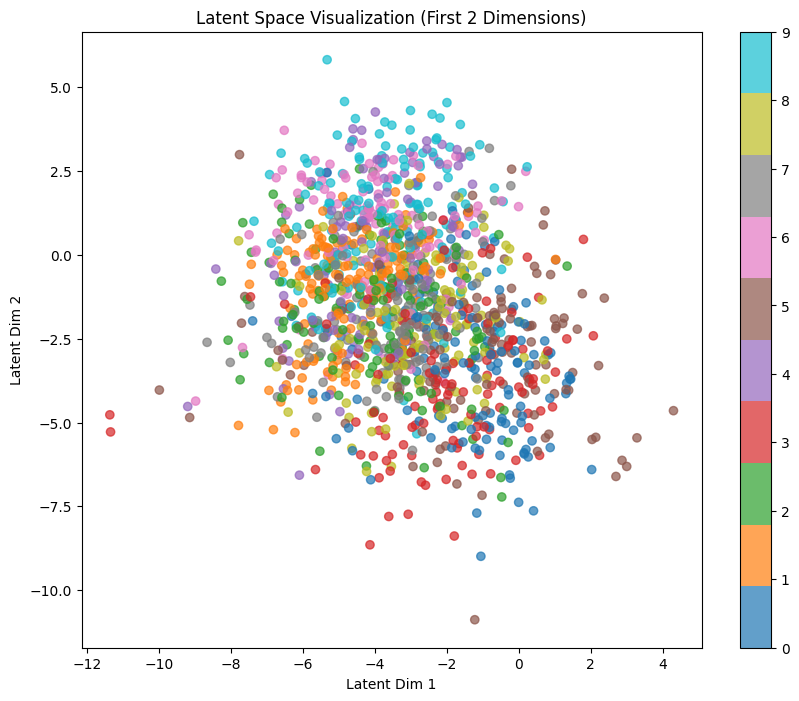

In [10]:
def compare_latent_space(model, data_loader):
    """Visualize how different digits cluster in latent space"""
    model.eval()

    latents = []
    labels = []

    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            latent = model.encode(data)
            latents.append(latent.cpu())
            labels.append(label)

            # Only collect a subset for visualization
            if len(latents) > 20:
                break

    latents = torch.cat(latents, dim=0)
    labels = torch.cat(labels, dim=0)

    # If latent space is high-dimensional, just plot first 2 dimensions
    if latent_dim >= 2:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latents[:, 0], latents[:, 1],
                            c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter)
        plt.title('Latent Space Visualization (First 2 Dimensions)')
        plt.xlabel('Latent Dim 1')
        plt.ylabel('Latent Dim 2')
        plt.show()

# Visualize latent space
compare_latent_space(model, train_loader)


In [11]:
print("CONGRATULATIONS! 🎉")
print("You've built your first image generation model!")
print()
print("WHAT YOU'VE LEARNED:")
print("✓ Autoencoders compress and reconstruct images")
print("✓ PyTorch tensors, datasets, and training loops")
print("✓ Forward/backward passes and gradient descent")
print("✓ Hyperparameter tuning and debugging")
print()
print("NEXT LEARNING STEPS:")
print("1. Try Variational Autoencoders (VAEs) for better generation")
print("2. Experiment with Convolutional layers for image data")
print("3. Learn about GANs (Generative Adversarial Networks)")
print("4. Try other datasets (CIFAR-10, CelebA)")
print("5. Implement different loss functions (perceptual loss)")


CONGRATULATIONS! 🎉
You've built your first image generation model!

WHAT YOU'VE LEARNED:
✓ Autoencoders compress and reconstruct images
✓ PyTorch tensors, datasets, and training loops
✓ Forward/backward passes and gradient descent
✓ Hyperparameter tuning and debugging

NEXT LEARNING STEPS:
1. Try Variational Autoencoders (VAEs) for better generation
2. Experiment with Convolutional layers for image data
3. Learn about GANs (Generative Adversarial Networks)
4. Try other datasets (CIFAR-10, CelebA)
5. Implement different loss functions (perceptual loss)
